In [1]:
import pickle
import numpy as np
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../input/smart-reply-sentence-similarity/target_texts.pickle", 'rb') as handle:
    target_texts = pickle.load(handle)

In [3]:
tqdm.pandas()
df = pd.read_csv("../input/smart-reply-sentence-similarity/target_similarity_matrix.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,[0.0,0.032343,0.043931,0.048926,0.115088,0.041877,0.041788,0.121827,0.076585,0.033120,...,0.018002,0.047614,0.056383,0.049183,0.025171,0.063747,0.110613,0.059824,0.081728,0.030597150325775146]
1,[0.03234344720840454,0.000000,0.044221,0.034011,0.081143,0.076799,0.034870,0.197947,0.124473,0.047499,...,0.039835,0.049093,0.055454,0.068492,0.028490,0.070785,0.111448,0.032470,0.118061,0.05808180570602417]
2,[0.04393130540847778,0.044221,0.000000,0.042794,0.087890,0.082446,0.048002,0.161995,0.100378,0.056737,...,0.051363,0.052489,0.061016,0.048156,0.047980,0.068565,0.093039,0.050996,0.116387,0.06303125619888306]
3,[0.048926472663879395,0.034011,0.042794,0.000000,0.053974,0.094880,0.028581,0.185860,0.128835,0.045072,...,0.064776,0.070877,0.021810,0.066524,0.060270,0.037493,0.104824,0.033249,0.152471,0.07287395000457764]
4,[0.11508768796920776,0.081143,0.087890,0.053974,0.000000,0.182095,0.076609,0.281628,0.213588,0.102450,...,0.144435,0.125256,0.065986,0.126967,0.116808,0.078543,0.150901,0.069894,0.223608,0.16020792722702026]


In [4]:
# first and last column data contains [ and ]
df.iloc[:,0]

0                        [0.0
1        [0.03234344720840454
2        [0.04393130540847778
3       [0.048926472663879395
4        [0.11508768796920776
                ...          
4996      [0.0637471079826355
4997     [0.11061316728591919
4998     [0.05982428789138794
4999     [0.08172768354415894
5000    [0.030597150325775146
Name: 0, Length: 5001, dtype: object

In [5]:
df.iloc[:,-1:]

,5000
0,0.030597150325775146]
1,0.05808180570602417]
2,0.06303125619888306]
3,0.07287395000457764]
4,0.16020792722702026]
...,...
4996,0.1009334921836853]
4997,0.11932098865509033]
4998,0.08614307641983032]
4999,0.05986034870147705]


In [6]:
# cleaning first and last columns
df.iloc[:,0] = df.iloc[:,0].str.replace("[", "").str.strip()
df.iloc[:,-1:] = df.iloc[:,-1].str.replace("]", "").str.strip()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
df.iloc[:,0]

0                        0.0
1        0.03234344720840454
2        0.04393130540847778
3       0.048926472663879395
4        0.11508768796920776
                ...         
4996      0.0637471079826355
4997     0.11061316728591919
4998     0.05982428789138794
4999     0.08172768354415894
5000    0.030597150325775146
Name: 0, Length: 5001, dtype: object

In [8]:
df.iloc[:,-1:]

,5000
0,0.030597150325775146
1,0.05808180570602417
2,0.06303125619888306
3,0.07287395000457764
4,0.16020792722702026
...,...
4996,0.1009334921836853
4997,0.11932098865509033
4998,0.08614307641983032
4999,0.05986034870147705


In [9]:
# converting datatype to float
target_similarity_matrix = df.astype(float)
target_similarity_matrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,...,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.052598,0.058754,0.064910,0.059378,0.115284,0.085590,0.062788,0.156358,0.110318,0.062612,...,0.060416,0.076456,0.067375,0.078247,0.059230,0.075143,0.121587,0.072752,0.124392,0.069087
std,0.022451,0.036892,0.024968,0.039210,0.057112,0.035074,0.040032,0.065667,0.040732,0.022542,...,0.027921,0.028193,0.037081,0.022122,0.027058,0.033788,0.024127,0.048546,0.043745,0.029184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.036411,0.033433,0.048156,0.030201,0.070807,0.058203,0.034186,0.111990,0.075688,0.047417,...,0.037654,0.054803,0.038121,0.060907,0.038766,0.050673,0.104804,0.037727,0.087782,0.046108
50%,0.049552,0.047380,0.057191,0.046087,0.096992,0.080945,0.052983,0.162496,0.107720,0.057343,...,0.059384,0.072210,0.060391,0.075127,0.056080,0.074941,0.116362,0.055592,0.119831,0.065979
75%,0.064647,0.072756,0.072697,0.077320,0.146050,0.110544,0.083677,0.203312,0.139709,0.070417,...,0.078235,0.092581,0.089792,0.092117,0.074317,0.098549,0.133463,0.091165,0.158251,0.088225
max,0.153418,0.218926,0.178593,0.205347,0.305896,0.216739,0.212692,0.333399,0.252106,0.172723,...,0.171838,0.199915,0.191004,0.167563,0.174877,0.186384,0.217767,0.254911,0.278069,0.185136


In [10]:
# finding 10th neighbour distance to sentence 1
target_similarity_matrix.iloc[1].nsmallest(10).iloc[10-1]

0.0096983313560485

In [11]:
# extending logic to all rows
def sort_and_select_10_neigh_dist(row):
    return row.nsmallest(10).iloc[10-1]

neighbor_10_dist = target_similarity_matrix.apply(sort_and_select_10_neigh_dist, axis = 1) 

In [12]:
neighbor_10_dist.describe()

count    5001.000000
mean        0.016887
std         0.013209
min         0.000000
25%         0.008559
50%         0.014066
75%         0.021688
max         0.107794
dtype: float64

In [13]:
for x in list(target_similarity_matrix.nsmallest(10, 1).index.astype(int)):
    print(target_texts[x], " - Similarity Score :", target_similarity_matrix[x][1]) 

i love to dance a lot. how about you  - Similarity Score : 0.0
i like listening to music. how about you  - Similarity Score : 0.0060844421386718
i love to be entertained. how about you  - Similarity Score : 0.0069478154182434
i like music drama and dance. how about you  - Similarity Score : 0.0077279210090637
i like to watch movies. what about you  - Similarity Score : 0.0084414482116699
i like many kinds of music. what about you  - Similarity Score : 0.0084562897682189
i'm doing great. how about you  - Similarity Score : 0.0086196064949035
i do like hockey. how about you  - Similarity Score : 0.0088279843330383
i absolutely love animals. how about you  - Similarity Score : 0.0096230506896972
i do like baseball. how about you  - Similarity Score : 0.0096983313560485


In [14]:
# using 40th percentile value as appropriate distance for 10th neighbour
eps_10 = neighbor_10_dist.quantile(0.99)
print(eps_10)

0.0645963549613952


In [15]:
eps_nums = list()
eps_num_clusters = list()
eps_num_noise = list()
trial_eps = np.linspace(0, neighbor_10_dist.quantile(1.0), num=200)

for eps_num in trial_eps:
    
    if eps_num > 0:    
        print("Taking EPS as", eps_num)
        # Compute DBSCAN
        db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_similarity_matrix)
        #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        #core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        eps_nums.append(eps_num)
        eps_num_clusters.append(n_clusters_)
        eps_num_noise.append(n_noise_)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("-----------")
        
        if n_clusters_ == 1:
            print("Stopping..")
            # least number of clusters
            break

Taking EPS as 0.0005416786251355654
Estimated number of clusters: 214
Estimated number of noise points: 4048
-----------
Taking EPS as 0.0010833572502711307
Estimated number of clusters: 217
Estimated number of noise points: 4036
-----------
Taking EPS as 0.001625035875406696
Estimated number of clusters: 228
Estimated number of noise points: 3998
-----------
Taking EPS as 0.0021667145005422614
Estimated number of clusters: 242
Estimated number of noise points: 3935
-----------
Taking EPS as 0.0027083931256778266
Estimated number of clusters: 255
Estimated number of noise points: 3867
-----------
Taking EPS as 0.003250071750813392
Estimated number of clusters: 270
Estimated number of noise points: 3766
-----------
Taking EPS as 0.0037917503759489577
Estimated number of clusters: 273
Estimated number of noise points: 3666
-----------
Taking EPS as 0.004333429001084523
Estimated number of clusters: 270
Estimated number of noise points: 3545
-----------
Taking EPS as 0.004875107626220088


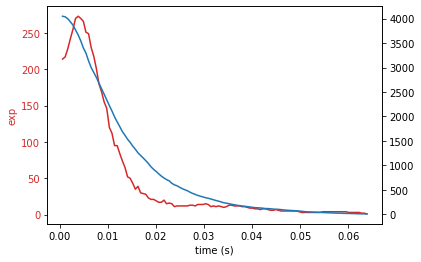

In [16]:
#figure(num=None, figsize=(15, 6), dpi=80)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(eps_nums, eps_num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.plot(eps_nums, eps_num_noise)
plt.show()

In [17]:
eps_num = 0.0037917503759489577
print("Taking EPS as", eps_num)
# Compute DBSCAN
db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_similarity_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.0037917503759489577
Estimated number of clusters: 273
Estimated number of noise points: 3666


In [18]:

from collections import Counter

for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(target_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency


In cluster 0 found 3 points
Samples
['yes i love fish do you' 'yes i love youtube do you'
 'yes i love music what about you']
-------------------------------------
In cluster 1 found 48 points
Samples
['thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.'
 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.' 'thanks.']
-------------------------------------
In cluster 2 found 30 points
Samples
['you too' 'you too' 'you too' 'you too' 'you too' 'you too' 'you too'
 'you too' 'you too' 'you as well' 'you as well' 'you too' 'you too'
 'you as well' 'you as well' 'you as well' 'you too' 'you too' 'you too'
 'you too' 'you too' 'y

In [19]:
with open('target_dbscan.pickle', 'wb') as handle:
    pickle.dump(db, handle, protocol=pickle.HIGHEST_PROTOCOL)